<a href="https://colab.research.google.com/github/Sinethemba-nongqoto/Research-project/blob/master/Sentiment_Classfication_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 1.x selected.


In [ ]:
#!pip install tensorflow==2.0.0

In [ ]:
#!pip install pyyaml h5py

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.0.0


## importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,Input, GlobalMaxPooling1D
from keras.layers.core import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import os 
import re
import shutil
import string 
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import pydot

# gensim
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


Using TensorFlow backend.


## reading data from google drive

In [ ]:
true_news = pd.read_csv('./drive/My Drive/Sentiment_analysis/True_v_False_news/COVID19-FNIR/trueNews.csv', sep=',')
false_news = pd.read_csv('./drive/My Drive/Sentiment_analysis/True_v_False_news/COVID19-FNIR/fakeNews.csv', sep=',')

## displaying head(top 10) of the data we just imported

In [ ]:
true_news.head()

,Date_Posted,Link,Text,Region,Username,Publisher,Binary_Label,Poynter_Label
0,02/11/2020,https://twitter.com/the_hindu/status/122725962...,Just in: Novel coronavirus named 'Covid-19': U...,India,the_hindu,The Hindu,1,True
1,02/12/2020,https://twitter.com/ndtv/status/12274908434742...,WHO officially names #coronavirus as Covid-19....,India,ndtv,NDTV,1,True
2,02/12/2020,https://twitter.com/the_hindu/status/122744471...,"The #UN #health agency announced that ""COVID-1...",India,the_hindu,The Hindu,1,True
3,2/14/20,https://twitter.com/IndiaToday/status/12282764...,The Indian Embassy in Tokyo has said that one ...,India,indiatoday,IndiaToday,1,True
4,2/15/20,https://twitter.com/the_hindu/status/122854247...,Ground Zero | How Kerala used its experience i...,India,the_hindu,The Hindu,1,True


In [ ]:
T_news= true_news.drop(['Date_Posted','Link', 'Username','Region','Publisher', 'Poynter_Label'], axis=1)
T_news.head()

,Text,Binary_Label
0,Just in: Novel coronavirus named 'Covid-19': U...,1
1,WHO officially names #coronavirus as Covid-19....,1
2,"The #UN #health agency announced that ""COVID-1...",1
3,The Indian Embassy in Tokyo has said that one ...,1
4,Ground Zero | How Kerala used its experience i...,1


In [ ]:
false_news.head()

,Date_Posted,Link,Text,Region,Country,Explanation,Origin,Origin_URL,Fact_checked_by,Poynter_Label,Binary_Label
0,02/07/2020,https://www.poynter.org/?ifcn_misinformation=t...,Tencent revealed the real number of deaths.\t\t,Europe,France,The screenshot is questionable.,Twitter,https://www.liberation.fr/checknews/2020/02/07...,CheckNews,False,0
1,02/07/2020,https://www.poynter.org/?ifcn_misinformation=t...,Taking chlorine dioxide helps fight coronavir...,Europe,Germany,Chlorine dioxide does guard against the corona...,Website,https://correctiv.org/faktencheck/medizin-und-...,Correctiv,False,0
2,02/07/2020,https://www.poynter.org/?ifcn_misinformation=t...,This video shows workmen uncovering a bat-inf...,India,India,A video shows bats nesting in the roof; howev...,Facebook,https://factcheck.afp.com/video-shows-workmen-...,AFP,False,0
3,02/07/2020,https://www.poynter.org/?ifcn_misinformation=t...,The Asterix comic books and The Simpsons pred...,India,India,Coronavirus has been around since the 1960s. T...,Twitter,https://www.boomlive.in/health/did-the-simpson...,BOOM FactCheck,False,0
4,02/07/2020,https://www.poynter.org/?ifcn_misinformation=c...,Chinese President Xi Jinping visited a mosque...,India,India,Chinese President Xi Jinping's visit to the mo...,Facebook,http://newsmobile.in/articles/2020/02/07/chine...,NewsMobile,False,0


In [ ]:
F_news= false_news.drop(['Date_Posted','Link', 'Country','Region','Explanation','Origin','Origin_URL', 'Fact_checked_by' ,'Poynter_Label'], axis=1)
F_news.head()

,Text,Binary_Label
0,Tencent revealed the real number of deaths.\t\t,0
1,Taking chlorine dioxide helps fight coronavir...,0
2,This video shows workmen uncovering a bat-inf...,0
3,The Asterix comic books and The Simpsons pred...,0
4,Chinese President Xi Jinping visited a mosque...,0


In [ ]:
# Concatenating the true news dataset and false news dataset into one dataframe
news_data = pd.concat([T_news,F_news])
print(news_data.head())
print('======================================')
print('The total number of data:',len(news_data))

                                                Text  Binary_Label
0  Just in: Novel coronavirus named 'Covid-19': U...             1
1  WHO officially names #coronavirus as Covid-19....             1
2  The #UN #health agency announced that "COVID-1...             1
3  The Indian Embassy in Tokyo has said that one ...             1
4  Ground Zero | How Kerala used its experience i...             1
The total number of data: 7588


In [ ]:
# Saving the dataset of the news data
news_data.to_csv(r'/content/sample_data/Covid19_news.csv', index = False)
news_data.to_csv(r'./drive/My Drive/Sentiment_analysis/True_v_False_news/COVID19-FNIR/Covid19_news.csv', index = False)

## Sentiment analysis

This notebook trains a sentiment analysis model to classify COVID-19 news as true news or false news, based on the text of the news. This is an binary- or two class-classification, an important and widely applicable kind of machine learning problem.

The dataset contains the text of 7588 news from the internet social media database. We will split by 80% training dataset and 20% validation dataset which will be 6,070 news for training and 1518 news for validation news.

The one category of true news and false news is balanced.

In [ ]:
# split for cross-validation (train 80%, and  valid 20% ------------and test 10%)
x_train, x_val, y_train, y_val = train_test_split(news_data['Text'].tolist(),news_data['Binary_Label'].tolist(), test_size=0.2, random_state=42)
#x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, test_size=0.5, random_state=42)

In [ ]:
print(len(x_train))
#print(len(x_test))
print(len(x_val))

6070
1518


In [ ]:
# save the training data, validation and testing data
train, valid = train_test_split(news_data, test_size=0.2, random_state=42)
#test, valid = train_test_split(test, test_size=0.5, random_state=42)
train.to_csv(r'/content/sample_data/train.csv', index = False)
#test.to_csv(r'/content/sample_data/test.csv', index = False)
valid.to_csv(r'/content/sample_data/valid.csv', index = False)

In [ ]:
print('train shape:',train.shape)
#print('test shape:',test.shape)
print('test shape:',valid.shape)

train shape: (6070, 2)
test shape: (1518, 2)


Let us define methods to pre-processing

we now preprocess the data

## Step1 : Text cleaning : 🧹

Regardless of the EDA step that can bring out the uncleaned elements and help us to customize the cleaning code, we can apply some basic data cleaning that are recurrent in tweeters such as removing punctuation, html tags urls and emojis,...

Below a python code that can be be reproduced in other similar use cases

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [ ]:
train_data= pd.read_csv(r'/content/sample_data/train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['Text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print('Rumoured news=0, and Non-rumoured news=1')
print(train_data['Binary_Label'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['Text'] = train_data['Text'].apply(remove_emoji)
train_data['Text'] = train_data['Text'].apply(remove_url)
train_data['Text'] = train_data['Text'].apply(clean_text)

valid_data= pd.read_csv(r'/content/sample_data/valid.csv')
valid_data.dropna(axis = 0, how ='any',inplace=True) 
valid_data['Num_words_text'] = valid_data['Text'].apply(lambda x:len(str(x).split())) 
max_valid_sentence_length  = valid_data['Num_words_text'].max()

mask = valid_data['Num_words_text'] >2
valid_data = valid_data[mask]
print('-------Validation data--------')
print('Rumoured news=0, and Non-rumoured news=1')
print(valid_data['Binary_Label'].value_counts())
print(len(valid_data))
print('-------------------------')

valid_data['Text'] = valid_data['Text'].apply(remove_emoji)
valid_data['Text'] = valid_data['Text'].apply(remove_url)
valid_data['Text'] = valid_data['Text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Validation Max Sentence Length :'+str(max_valid_sentence_length))

#all_sentences = train_data['text'].tolist() + valid_data['text'].tolist()

-------Train data--------
Rumoured news=0, and Non-rumoured news=1
0    3055
1    3007
Name: Binary_Label, dtype: int64
6062
-------------------------
-------Validation data--------
Rumoured news=0, and Non-rumoured news=1
1    786
0    729
Name: Binary_Label, dtype: int64
1515
-------------------------
Train Max Sentence Length :84
Validation Max Sentence Length :82


# Step 2: Text pre-processing 

As mentioned before, machine learning algorithms take numbers as inputs, not text, which means that we need to convert the texts into numerical vectors.
We proceed as follows:
## 1. Tokenization

It consists in dividing the texts into words or smaller sub-texts, allowing us to determine the “vocabulary” of the dataset (set of unique tokens present in the data). Usually we use word-level representation. For our exemple we will use NLTK Tokenizer()
## 2. Word indexing:

Construct a vocablary_index mapper based on word frequency: the index would be inversely proportional to the word occurrence frequency in the overall dataset. the most frequent world would have index=1.. And every single word would get a unique index.

These two steps are factorized as follows:

In [ ]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_train))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_train) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=90)
x_val_seq = pad_sequences(x_val_seq, maxlen=90)

Let’s take a glance at the number of unique words in the training data:

In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

15911


We will build two different (Word2Vec and GloVe) NLP models of the same architecture. The first model learns embeddings from scratch and the second model uses pretrained word embeddings.

Defining the architecture – Learning Embeddings from scratch:

In [ ]:
#deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=90,trainable=True)) 

#convolutional layer
model.add(Conv1D(128,2, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.01),\
                                 bias_regularizer = regularizers.l2(0.01)))

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#GlobalMaxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 
 
#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 300)           4773300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 89, 128)           76928     
_________________________________________________________________
lstm_1 (LSTM)                (None, 89, 128)           131584    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,990,133
Trainable params: 4,990,133
Non-trainable params: 0
____________________________________________

The total number of trainable parameters in the model is 4,990,133. Out of this, the Embedding layer contributes to 4,773,300 parameters and convulation layer contributes to 76928 parameters. That’s huge!, with high trainable parameters like this this might slower down the training process

Training the model:

In [ ]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=128,epochs=20,validation_data=(np.array(x_val_seq),np.array(y_val)),verbose=1,callbacks=[es,mc])

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6070 samples, validate on 1518 samples
Epoch 1/20
6070/6070 [==============================] - 35s 6ms/step - loss: 1.2046 - acc: 0.8995 - val_loss: 0.4036 - val_acc: 0.9855

Epoch 00001: val_acc improved from -inf to 0.98551, saving model to best_model.h5
Epoch 2/20
6070/6070 [==============================] - 34s 6ms/step - loss: 0.1896 - acc: 0.9969 - val_loss: 0.1038 - val_acc: 0.9908

Epoch 00002: val_acc improved from 0.98551 to 0.99078, saving model to best_model.h5
Epoch 3/20
6070/6070 [==============================] - 34s 6ms/step - loss: 0.0461 - acc: 0.9998 - val_loss: 0.0590 - val_acc: 0.9875

Epoch 00003: val_acc did not improve from 0.99078
Epoch 4/20
6070/6070 [==============================] - 34s 6ms/step - loss: 0.0176 - acc: 0.9998 - val_loss: 0.0504 - val_acc: 0.9881

Epoch 00004: val_acc did not improve from 0.99078
Epoch 5/20
6070/6070 [==============================] - 34s 6ms/step - loss: 0.0090 - acc: 0.9997 - val_loss: 0.0596 - val_acc: 0.9888

Epoch

The plot for loss between the training set and validation set.

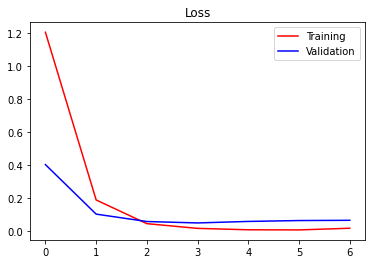

In [ ]:
plt.figure(0)

plt.title("Loss")

plt.plot(history.history['loss'], 'r', label='Training')

plt.plot(history.history['val_loss'], 'b', label='Validation')

plt.legend()

plt.show()

The plot for accuracy between the training set and validation set.

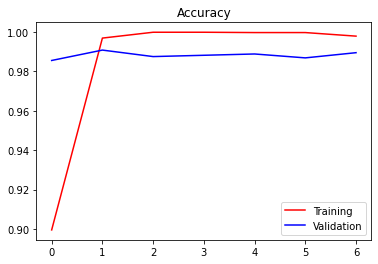

In [ ]:
plt.figure(1)

plt.title("Accuracy")

plt.plot(history.history['acc'], 'r', label='Training')

plt.plot(history.history['val_acc'], 'b', label='Validation')

plt.legend()

plt.show()

To get the validation performances results, use the `evaluate()` method:

Evaluating the performance of the model:

In [ ]:
#loading best model
from keras.models import load_model
#model = load_model('/content/best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_val, batch_size=128)
print(val_acc)

1518/1518 [==============================] - 2s 1ms/step
0.9894598126411438


# Construct an embedding Matrix 

First of we will download Glove pre-trained embedding from the official site, (because of some technical constraints I had to download it via a code :

In [ ]:
import os
import tqdm
import requests
import zipfile
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"

def fetch_data(url=URL, target_file='glove.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return

    #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)

fetch_data()

datasets already downloded :) 


Now, it’s time to build version II using GloVe pretrained word embeddings. Let us load the GloVe embeddings into our environment:

In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1917494 word vectors.


Create an embedding matrix by assigning the vocabulary with the pretrained word embeddings:

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Defining the Architecture – Pretrained embeddings:

In [ ]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=90,trainable=False)) 

#convolutional layer
model.add(Conv1D(128,2, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.01),\
                                 bias_regularizer = regularizers.l2(0.01)))

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 90, 300)           4773300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 128)           76928     
_________________________________________________________________
lstm_2 (LSTM)                (None, 89, 128)           131584    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,990,133
Trainable params: 216,833
Non-trainable params: 4,773,300
______________________________________

As you can see here, the number of trainable parameters is just 216,833. That’s a huge drop compared to the embedding layer.

Training the model:

In [ ]:
#fine tunning the model
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=128,epochs=20,validation_data=(np.array(x_val_seq),np.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 6070 samples, validate on 1518 samples
Epoch 1/20
6070/6070 [==============================] - 29s 5ms/step - loss: 1.1355 - acc: 0.9265 - val_loss: 0.3796 - val_acc: 0.9842

Epoch 00001: val_acc improved from -inf to 0.98419, saving model to best_model.h5
Epoch 2/20
6070/6070 [==============================] - 28s 5ms/step - loss: 0.1896 - acc: 0.9903 - val_loss: 0.1002 - val_acc: 0.9914

Epoch 00002: val_acc improved from 0.98419 to 0.99144, saving model to best_model.h5
Epoch 3/20
6070/6070 [==============================] - 28s 5ms/step - loss: 0.0655 - acc: 0.9942 - val_loss: 0.0632 - val_acc: 0.9895

Epoch 00003: val_acc did not improve from 0.99144
Epoch 4/20
6070/6070 [==============================] - 28s 5ms/step - loss: 0.0474 - acc: 0.9939 - val_loss: 0.0821 - val_acc: 0.9835

Epoch 00004: val_acc did not improve from 0.99144
Epoch 5/20
6070/6070 [==============================] - 28s 5ms/step - loss: 0.0473 - acc: 0.9937 - val_loss: 0.0468 - val_acc: 0.9934

Epoch

The plot for loss between the training set and validation set.

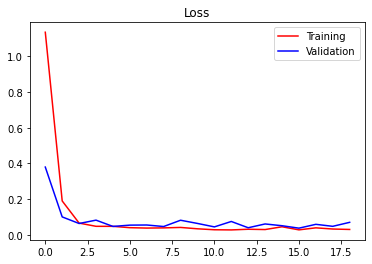

In [ ]:
plt.figure(3)

plt.title("Loss")

plt.plot(history.history['loss'], 'r', label='Training')

plt.plot(history.history['val_loss'], 'b', label='Validation')

plt.legend()

plt.show()

The plot for accuracy between the training and validatation

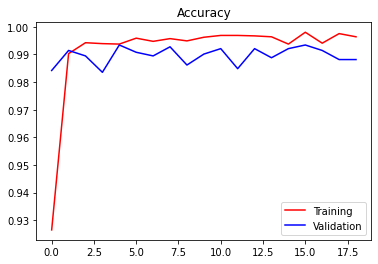

In [ ]:
plt.figure(4)

plt.title("Accuracy")

plt.plot(history.history['acc'], 'r', label='Training')

plt.plot(history.history['val_acc'], 'b', label='Validation')

plt.legend()

plt.show()

Evaluating the performance of the model:

In [ ]:
#loading best model
from keras.models import load_model
#model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_val, batch_size=128)
print(val_acc)

1518/1518 [==============================] - 2s 1ms/step
0.9881423115730286


The performance has increased using pretrained word embeddings compared to learning embeddings from scratch.

Pretrained word embeddings are the most powerful way of representing a text as they tend to capture the semantic and syntactic meaning of a word. We have learned the importance of pretrained word embeddings and discussed 2 popular pretrained word embeddings – Word2Vec and gloVe.